# Predicting Brand Sentiment on Twitter

- Nick Gigliotti
- [ndgigliotti@gmail.com](ndgigliotti@gmail.com)

<div><img src="images/apple_logo_black.svg", width=100></div>

# Business Problem

Apple has asked me to create a strong predictive model for detecting positive, negative, and neutral sentiment in tweets. They are primarily concerned with tweets about their company and products, but also might want to know what people are saying about competitors. They intend to use the model to classify new, never-before-seen tweets in order to conduct their research. My goals are:

1. Create an accurate classifier which can classify **novel tweets** as positive, negative, or neutral.
2. Find out what people are saying about Apple (at South by Southwest, 2011).
3. Make some PR recommendations for the period immediately following the event.

# Imports
Because there are so many of them, I've created a separate section.
## Standard Library and External

In [1]:
import re
import string
import json
from pprint import pprint
from functools import partial
from operator import itemgetter, attrgetter
from os.path import normpath
from typing import Callable

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns

# from sacremoses import MosesTokenizer, MosesTruecaser
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    SelectPercentile,
    GenericUnivariateSelect,
)
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import (
    LogisticRegression,
    Perceptron,
    PassiveAggressiveClassifier,
    RidgeClassifier,
    SGDClassifier,
)
from sklearn.naive_bayes import (
    ComplementNB,
    MultinomialNB,
)
from sklearn.svm import LinearSVC, NuSVC, OneClassSVM, SVC
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import (
    Binarizer,
    FunctionTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    PolynomialFeatures,
)

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1, style="darkgrid")
sns.set_context("notebook")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## My `tools` Package

I put a lot of time and energy into developing my own tools for analysis. It's probably my favorite part of this kind of work, and I (admittedly) tend to get carried away with it. I developed a lot in `tools.language`, `tools.sklearn.vectorizers`, and `tools.sklearn.selection` for this project in particular.

#### Caching

Some computationally expensive functions in `tools.language` implement caching, allowing them to save the results of previous calls and reuse them. This **dramatically increases their performance** when being called over and over again as part of a preprocessing pipeline. Essentially, after the function has been called once with certain parameters, every subsequent call with those parameters is fulfilled instantly. This is a highly non-trivial development, which increases the speed of parameter searches (e.g. with `GridSearchCV`) and makes model development more efficient in general.

#### Polymorphism

I've designed the raw-text processing functions in `tools.language` to be polymorphic: capable of handling both a single string document and various types of iterables of documents. This level of flexibility is arguably overkill for the present task.

#### FreqVectorizer

I extended Scikit-Learn's `TfidfVectorizer` to be capable of much more advanced preprocessing out of the box. In addition to the many new text filters, there's built-in stemming and lemmatization, better stopwords selection, and the option to mark negation or parts of speech. See [My `FreqVectorizer`](#my-freqvectorizer) and what comes after for more details.


#### VaderVectorizer

Another notable development is the `VaderVectorizer`, which extracts VADER (Valence Aware Dictionary and Sentiment Reasoner) polarity scores from documents and turns them into short vectors of shape (n_samples, 4). This is essentially just a fancy wrapper around the VADER tools from NLTK, which integrates them with the Scikit-Learn API and implements caching. It proved very useful for the current project. See [Add `VaderVectorizer`](#add-vadervectorizer) and what follows.

#### See also:

[My `sweep` Function](#my-sweep-function) for my generic parameter-space searching function.

In [2]:
# Import my modules
from tools import cleaning, plotting, outliers, language as lang, utils
from tools.sklearn.vectorizers import FreqVectorizer, VaderVectorizer
from tools.sklearn import selection

# Run time-consuming grid searches
RUN_SWEEPS = False

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# RandomState for reproducibility
rando = np.random.RandomState(9547)

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv("data/sentiment140.csv", header=None, usecols=[0, 5])
df.columns = ["polarity", "text"]
df

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


<IPython.core.display.Javascript object>

In [4]:
cleaning.info(df)

,null,null_%,uniq,uniq_%,dup,dup_%
polarity,0,0.0,2,0.00,16309,1.02
text,0,0.0,1581466,98.84,16309,1.02


<IPython.core.display.Javascript object>

In [5]:
# sxsw = pd.read_csv(normpath("data/crowdflower_tweets.csv"))
# sxsw.drop(columns="emotion_in_tweet_is_directed_at", inplace=True)
# sxsw.head()

<IPython.core.display.Javascript object>

The dataset contains one text feature and two categorical features, one of which has a lot of null values. The feature names are very long and wordy, presumably to reflect the actual language used by CrowdFlower in crowdsourcing the dataset. I'm going to rename those before I do anything else.

# Cleaning
## Renaming

In [6]:
df["polarity"] = df["polarity"].astype(bool).astype(np.uint8)
df["polarity"].unique()

array([0, 1], dtype=uint8)

<IPython.core.display.Javascript object>

(0.0, 0.75)

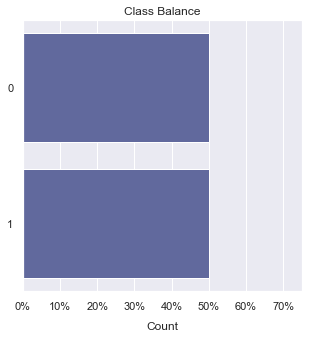

<IPython.core.display.Javascript object>

In [7]:
ax = plotting.countplot(df["polarity"], normalize=True)
ax.set(title="Class Balance")
ax.set_xlim((0, 0.75))

# Modeling

I develop my final model through an iterative process, starting with a basic, baseline version of the model.

Before I do anything, I turn my nested lists of brand terms into strings which can be vectorized. Vectorization is just a convenient way to one-hot-encode them.

## Train-Test-Split

I perform the train-test split which I'll use throughout my modeling process. I let `X` and its derivatives be `DataFrame` objects because I plan to use a `ColumnTransformer` to process the two columns separately.

In [8]:
# Define X and y
X = df["text"].copy()
y = df["polarity"].copy()

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=rando,
    stratify=y,
    shuffle=True,
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1200000,), (1200000,), (400000,), (400000,))

<IPython.core.display.Javascript object>

In [9]:
help(FreqVectorizer)

Help on class FreqVectorizer in module tools.sklearn.vectorizers:

class FreqVectorizer(sklearn.feature_extraction.text.TfidfVectorizer, VectorizerMixin)
 |  FreqVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, decode_html_entities=True, lowercase=True, strip_extra_space=False, strip_numeric=False, pad_numeric=False, strip_non_word=False, strip_punct=False, strip_twitter_handles=False, strip_html_tags=False, limit_repeats=False, uniq_char_thresh=None, stemmer=None, preprocessor=None, tokenizer=None, token_pattern='\\b\\w\\w+\\b', analyzer='word', stop_words=None, process_stop_words=True, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm=None, use_idf=False, smooth_idf=True, sublinear_tf=False)
 |  
 |  Convert a collection of raw documents to a matrix of word-frequency features.
 |  
 |  Extends Scikit-Learn's `TfidfVectorizer` with advanced preprocessing options.
 |

<IPython.core.display.Javascript object>

## Baseline Model: Logistic Regression

I create a `LogisticRegression` classifier. Logistic Regression is my go-to option for classification, and it performs well on this dataset. Since the `y` classes are wildly imbalanced, I set `class_weight='balanced'`. I also hike up `max_iter` because otherwise the model fails to converge.

In [10]:
sgd = SGDClassifier(class_weight="balanced", n_jobs=-1)
sgd

SGDClassifier(class_weight='balanced', n_jobs=-1)

<IPython.core.display.Javascript object>

In [11]:
fv = FreqVectorizer()

<IPython.core.display.Javascript object>

I create my main `Pipeline`, consisting simply of `col_xform` and `logit`.

In [12]:
pipe = Pipeline(
    [
        ("vec", fv),
        ("cls", sgd),
    ],
    verbose=True,
    memory="pipe_cache",
)
pipe

Pipeline(memory='pipe_cache',
         steps=[('vec', FreqVectorizer()),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

In [13]:
# Make copy of baseline for future reference
baseline = clone(pipe)

<IPython.core.display.Javascript object>

### Fitting the Model

In [14]:
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 2 of 2) Processing cls, total=   3.5s


Pipeline(memory='pipe_cache',
         steps=[('vec', FreqVectorizer()),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Accuracy: 0.79, Balanced Accuracy: 0.79'}, xlabel='Predicted Value', ylabel='True Value'>

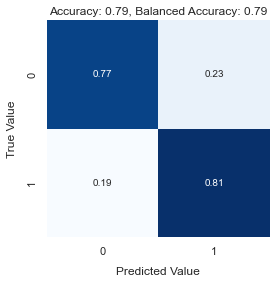

<IPython.core.display.Javascript object>

In [15]:
plotting.confusion_matrix(pipe, X_test, y_test, size=(4, 4))

Not the best model I've ever seen, but it's a baseline. The text is being count-vectorized, which is a pretty crude strategy. That'll be the first thing to change.

### Compare with Dummy

The baseline, while crude, is much better than the dummy model. This `DummyClassifier` algorithm randomly selects classes with probability weighted according to the class balance. With this dataset, it almost never selects Negative, and it's a 60-30 split between Neutral and Positive.

In [57]:
dummy = DummyClassifier(strategy="stratified", random_state=15)
dummy_pipe = clone(pipe).set_params(cls=dummy)
dummy_pipe.fit(X_train, y_train)

[Pipeline] ............... (step 2 of 2) Processing cls, total=   0.0s


Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FreqVectorizer(ngram_range=(1, 2), stemmer='wordnet',
                                stop_words={'#sxsw', '#sxswi', 'a', 'about',
                                            'above', 'after', 'again',
                                            'against', 'ain', 'all', 'am',
                                            'america', 'an', 'and', 'any',
                                            'are', 'aren', "aren't", 'as', 'at',
                                            'austin', 'be', 'because', 'been',
                                            'before', 'being', 'below',
                                            'between', 'both', 'but', ...},
                                strip_accents='ascii'...
                                            '#agchat': 12, '#agileagency': 13,
                                            '#agnerd': 14, '#airline': 15,
                                            '#airplane': 1

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Accuracy: 0.47, Balanced Accuracy: 0.33'}, xlabel='Predicted Value', ylabel='True Value'>

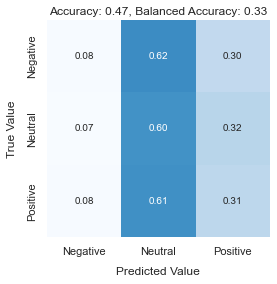

<IPython.core.display.Javascript object>

In [58]:
plotting.confusion_matrix(
    dummy_pipe, X_test, y_test, labels=dummy_pipe["cls"].classes_, size=(4, 4)
)

### My `sweep` Function

My `selection.sweep` function is a generic function for searching parameter spaces using Scikit-Learn. If you pass `kind='grid'`, it fits a `GridSearchCV`, running an exhaustive search over every combination of parameters. This is the default (and most thorough) option. You can also pass `kind='rand'` to fit a `RandomizedSearchCV`, which searches a random sample of the parameter space. If you want to speed things up, you can pass `kind='hgrid'` or `kind='hrand'` to fit Scikit-Learn's experimental `HalvingGridSearchCV` or its randomized counterpart. The "halving" searches try to weed out the weak candidates using only a small amount of computational resources (e.g. a small sample of the data).

Rather than returning a `GridSearchCV` object or equivalent, `selection.sweep` immediately serializes the search estimator and saves it via `joblib`. This is done to prevent loss of the search results. It's very easy to load a serialized search estimator, and I have a function `selection.load_results` which trims down the `cv_results_` and returns a `DataFrame`.

First, I run a quick search to see which solvers are efficient for this dataset.

In [59]:
cls_grid = {
    "cls": [
        LogisticRegression(class_weight="balanced", max_iter=1000),
        RandomForestClassifier(class_weight="balanced"),
        ExtraTreesClassifier(class_weight="balanced"),
        ComplementNB(),
        SVC(class_weight="balanced"),
        LinearSVC(class_weight="balanced"),
    ],
    "vec__binary": [True, False],
    "vec__norm": ["l2", "l1", None],
    "vec__use_idf": [True, False],
}
cls_grid

{'cls': [LogisticRegression(class_weight='balanced', max_iter=1000),
  RandomForestClassifier(class_weight='balanced'),
  ExtraTreesClassifier(class_weight='balanced'),
  ComplementNB(),
  SVC(class_weight='balanced'),
  LinearSVC(class_weight='balanced')],
 'vec__binary': [True, False],
 'vec__norm': ['l2', 'l1', None],
 'vec__use_idf': [True, False]}

<IPython.core.display.Javascript object>

In [60]:
if RUN_SWEEPS:
    selection.sweep(
        pipe,
        cls_grid,
        cv_dst="sweeps/classifier_cv.joblib",
        X=X_train,
        y=y_train,
        scoring="balanced_accuracy",
        n_jobs=-1,
    )

<IPython.core.display.Javascript object>

In [61]:
cls_results = joblib.load("sweeps/classifier_cv.joblib")
cls_results = selection.prune_cv(cls_results)
cls_results.head(10)

,param_cls,binary,norm,use_idf,params,mean_fit_time,mean_score,rank_score
0,LogisticRegression(class_weight='balanced'),False,l2,True,{'cls': LogisticRegression(class_weight='balan...,12.334403,0.596706,1
1,LogisticRegression(class_weight='balanced'),True,l1,True,{'cls': LogisticRegression(class_weight='balan...,12.356004,0.595923,2
2,LogisticRegression(class_weight='balanced'),True,l2,True,{'cls': LogisticRegression(class_weight='balan...,15.384117,0.594060,3
3,LogisticRegression(class_weight='balanced'),False,l1,True,{'cls': LogisticRegression(class_weight='balan...,11.979002,0.592602,4
4,LogisticRegression(class_weight='balanced'),False,l2,False,{'cls': LogisticRegression(class_weight='balan...,12.384401,0.591138,5
5,LogisticRegression(class_weight='balanced'),True,l2,False,{'cls': LogisticRegression(class_weight='balan...,14.244313,0.588243,6
6,LogisticRegression(class_weight='balanced'),True,None,False,{'cls': LogisticRegression(class_weight='balan...,12.450404,0.586159,7
7,LogisticRegression(class_weight='balanced'),False,None,False,{'cls': LogisticRegression(class_weight='balan...,12.770599,0.584310,8
8,LinearSVC(class_weight='balanced'),False,l2,False,"{'cls': LinearSVC(class_weight='balanced'), 'v...",13.090601,0.571851,9
9,LinearSVC(class_weight='balanced'),False,l2,True,"{'cls': LinearSVC(class_weight='balanced'), 'v...",12.402399,0.569959,10


<IPython.core.display.Javascript object>

Constructing document vectors with raw **term frequencies** is a very crude approach. Words like 'the', if not filtered out, will have a high frequency in many tweets. But 'the' contains no information about the tweet's overall content. The TF\*IDF algorithm addresses this problem by normalizing term frequencies according to **inverse document frequency**. A term's inverse document frequency is the (logarithmically scaled) number of documents in the corpus divided by the number of documents containing the term. It represents the rarity of a term.

I lay out the TF\*IDF parameters which determine whether `FreqVectorizer` produces binary occurrence vectors, count vectors, normalized occurrence vectors, or normalized TF\*IDF vectors. The 'norm' often strongly affects model quality, so I've included that too.

In [62]:
pipe.set_params(**cls_results.loc[0, "params"])
pipe["cls"].set_params(max_iter=1000, n_jobs=-1)
pipe

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FreqVectorizer(ngram_range=(1, 2), norm='l2',
                                stemmer='wordnet',
                                stop_words={'#sxsw', '#sxswi', 'a', 'about',
                                            'above', 'after', 'again',
                                            'against', 'ain', 'all', 'am',
                                            'america', 'an', 'and', 'any',
                                            'are', 'aren', "aren't", 'as', 'at',
                                            'austin', 'be', 'because', 'been',
                                            'before', 'being', 'below',
                                            'between', 'both', 'but', ...},
                                strip_accen...
                                            '#agchat': 12, '#agileagency': 13,
                                            '#agnerd': 14, '#airline': 15,
                         

<IPython.core.display.Javascript object>

In [63]:
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 2 of 2) Processing cls, total=   0.9s


Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FreqVectorizer(ngram_range=(1, 2), norm='l2',
                                stemmer='wordnet',
                                stop_words={'#sxsw', '#sxswi', 'a', 'about',
                                            'above', 'after', 'again',
                                            'against', 'ain', 'all', 'am',
                                            'america', 'an', 'and', 'any',
                                            'are', 'aren', "aren't", 'as', 'at',
                                            'austin', 'be', 'because', 'been',
                                            'before', 'being', 'below',
                                            'between', 'both', 'but', ...},
                                strip_accen...
                                            '#agchat': 12, '#agileagency': 13,
                                            '#agnerd': 14, '#airline': 15,
                         

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Accuracy: 0.65, Balanced Accuracy: 0.58'}, xlabel='Predicted Value', ylabel='True Value'>

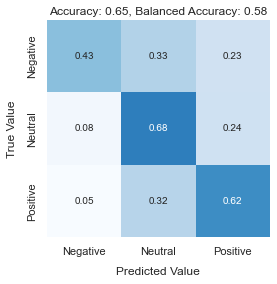

<IPython.core.display.Javascript object>

In [64]:
plotting.confusion_matrix(
    pipe, X_test, y_test, labels=pipe["cls"].classes_, size=(4, 4)
)

<a id='add-vadervectorizer'></a>

## Add `VaderVectorizer`

I add a new vectorizer to the mix which performs VADER (Valence Aware Dictionary and sEntiment Reasoner) analysis on each tweet and returns the polarity scores as vectors.

In [65]:
vad = VaderVectorizer()
vad

VaderVectorizer()

<IPython.core.display.Javascript object>

In [66]:
fu = FeatureUnion(
    [
        ("freq", fv),
        ("vad", vad),
    ],
    verbose=True,
)
fu

FeatureUnion(transformer_list=[('freq',
                                FreqVectorizer(ngram_range=(1, 2),
                                               stemmer='wordnet',
                                               stop_words={'#sxsw', '#sxswi',
                                                           'a', 'about',
                                                           'above', 'after',
                                                           'again', 'against',
                                                           'ain', 'all', 'am',
                                                           'america', 'an',
                                                           'and', 'any', 'are',
                                                           'aren', "aren't",
                                                           'as', 'at', 'austin',
                                                           'be', 'because',
                                                   

<IPython.core.display.Javascript object>

In [67]:
pipe.set_params(vec=fu)

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('freq',
                                                 FreqVectorizer(ngram_range=(1,
                                                                             2),
                                                                stemmer='wordnet',
                                                                stop_words={'#sxsw',
                                                                            '#sxswi',
                                                                            'a',
                                                                            'about',
                                                                            'above',
                                                                            'after',
                                                                            'again',
                                                     

<IPython.core.display.Javascript object>

[Pipeline] ............... (step 2 of 2) Processing cls, total=   1.5s


<AxesSubplot:title={'center':'Accuracy: 0.68, Balanced Accuracy: 0.60'}, xlabel='Predicted Value', ylabel='True Value'>

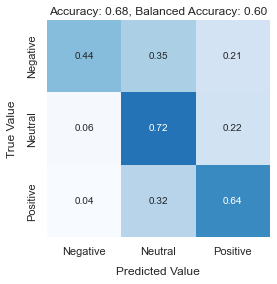

<IPython.core.display.Javascript object>

In [68]:
pipe.fit(X_train, y_train)
plotting.confusion_matrix(
    pipe, X_test, y_test, labels=pipe["cls"].classes_, size=(4, 4)
)

In [69]:
if "norm" not in pipe.named_steps:
    pipe.steps.insert(-1, ("norm", "passthrough"))
pipe

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('freq',
                                                 FreqVectorizer(ngram_range=(1,
                                                                             2),
                                                                stemmer='wordnet',
                                                                stop_words={'#sxsw',
                                                                            '#sxswi',
                                                                            'a',
                                                                            'about',
                                                                            'above',
                                                                            'after',
                                                                            'again',
                                                     

<IPython.core.display.Javascript object>

In [70]:
vad_grid = {
    "vec__vad__trinarize": [True, False],
    "vec__vad__compound": [True, False],
    "vec__vad__norm": ["l2", "l1", None],
    "norm": [Normalizer(), Normalizer("l1"), "passthrough"],
}
vad_grid

{'vec__vad__trinarize': [True, False],
 'vec__vad__compound': [True, False],
 'vec__vad__norm': ['l2', 'l1', None],
 'norm': [Normalizer(), Normalizer(norm='l1'), 'passthrough']}

<IPython.core.display.Javascript object>

In [71]:
if RUN_SWEEPS:
    selection.sweep(
        pipe,
        vad_grid,
        cv_dst="sweeps/vader_cv.joblib",
        X=X_train,
        y=y_train,
        kind="grid",
        scoring="balanced_accuracy",
        n_jobs=-1,
    )

<IPython.core.display.Javascript object>

In [72]:
vad_results = joblib.load("sweeps/vader_cv.joblib")
vad_results = selection.prune_cv(vad_results)
vad_results.head(10)

,param_norm,compound,norm,trinarize,params,mean_fit_time,mean_score,rank_score
0,Normalizer(),True,None,True,"{'norm': Normalizer(), 'vec__vad__compound': T...",18.948799,0.625084,1
1,Normalizer(),True,l2,True,"{'norm': Normalizer(), 'vec__vad__compound': T...",22.417198,0.623733,2
2,Normalizer(),False,None,True,"{'norm': Normalizer(), 'vec__vad__compound': F...",18.564000,0.621736,3
3,Normalizer(),True,l1,True,"{'norm': Normalizer(), 'vec__vad__compound': T...",18.487998,0.621344,4
4,Normalizer(),False,l2,True,"{'norm': Normalizer(), 'vec__vad__compound': F...",17.993799,0.621091,5
5,Normalizer(),False,l1,True,"{'norm': Normalizer(), 'vec__vad__compound': F...",18.120999,0.620974,6
6,Normalizer(),True,l1,False,"{'norm': Normalizer(), 'vec__vad__compound': T...",19.052997,0.618677,7
7,Normalizer(),True,None,False,"{'norm': Normalizer(), 'vec__vad__compound': T...",18.440998,0.617520,8
8,Normalizer(),True,l2,False,"{'norm': Normalizer(), 'vec__vad__compound': T...",1.453000,0.616710,9
9,passthrough,True,l1,True,"{'norm': 'passthrough', 'vec__vad__compound': ...",1.829398,0.612831,10


<IPython.core.display.Javascript object>

In [73]:
pipe.set_params(**vad_results.loc[0, "params"])

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('freq',
                                                 FreqVectorizer(ngram_range=(1,
                                                                             2),
                                                                stemmer='wordnet',
                                                                stop_words={'#sxsw',
                                                                            '#sxswi',
                                                                            'a',
                                                                            'about',
                                                                            'above',
                                                                            'after',
                                                                            'again',
                                                     

<IPython.core.display.Javascript object>

[Pipeline] ............... (step 3 of 3) Processing cls, total=   1.0s


<AxesSubplot:title={'center':'Accuracy: 0.63, Balanced Accuracy: 0.61'}, xlabel='Predicted Value', ylabel='True Value'>

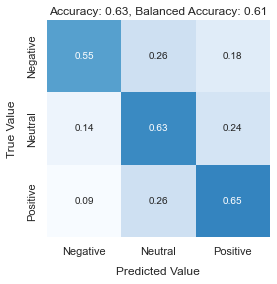

<IPython.core.display.Javascript object>

In [74]:
pipe.fit(X_train, y_train)
plotting.confusion_matrix(
    pipe, X_test, y_test, labels=pipe["cls"].classes_, size=(4, 4)
)

In [82]:
logit_grid = [
    # lbfgs & newton-cg: L2
    {
        "cls__C": sp.stats.loguniform(1e-4, 1e4),
        "cls__fit_intercept": [True, False],
        "cls__multi_class": ["multinomial", "ovr"],
        "cls__solver": ["lbfgs", "newton-cg"],
        "cls__penalty": ["l2"],
    },
    # liblinear: L1
    {
        "cls__C": sp.stats.loguniform(1e-4, 1e4),
        "cls__fit_intercept": [True, False],
        "cls__multi_class": ["ovr"],
        "cls__solver": ["liblinear"],
        "cls__penalty": ["l1"],
    },
    # liblinear: L2 & dual
    {
        "cls__C": sp.stats.loguniform(1e-4, 1e4),
        "cls__dual": [True, False],
        "cls__fit_intercept": [True, False],
        "cls__multi_class": ["ovr"],
        "cls__solver": ["liblinear"],
        "cls__penalty": ["l2"],
    },
]
logit_grid

[{'cls__C': <scipy.stats._distn_infrastructure.rv_frozen at 0x1f23ed39ee0>,
  'cls__fit_intercept': [True, False],
  'cls__multi_class': ['multinomial', 'ovr'],
  'cls__solver': ['lbfgs', 'newton-cg'],
  'cls__penalty': ['l2']},
 {'cls__C': <scipy.stats._distn_infrastructure.rv_frozen at 0x1f2353df490>,
  'cls__fit_intercept': [True, False],
  'cls__multi_class': ['ovr'],
  'cls__solver': ['liblinear'],
  'cls__penalty': ['l1']},
 {'cls__C': <scipy.stats._distn_infrastructure.rv_frozen at 0x1f23ea0ff70>,
  'cls__dual': [True, False],
  'cls__fit_intercept': [True, False],
  'cls__multi_class': ['ovr'],
  'cls__solver': ['liblinear'],
  'cls__penalty': ['l2']}]

<IPython.core.display.Javascript object>

In [83]:
if RUN_SWEEPS:
    selection.sweep(
        pipe,
        logit_grid,
        cv_dst="sweeps/logit_cv.joblib",
        X=X_train,
        y=y_train,
        kind="rand",
        n_iter=100,
        scoring="balanced_accuracy",
        n_jobs=-1,
    )

C:\Users\ndgig\Documents\Flatiron\Phase4\dsc-phase-4-project\tools\_validation.py:101: UserWarning: 'logit_cv.joblib' already exists and will be overwritten.
  warnings.warn(f"'{basename}' already exists and will be overwritten.")


Fitting 5 folds for each of 100 candidates, totalling 500 fits


['sweeps\\logit_cv.joblib']

<IPython.core.display.Javascript object>

In [85]:
logit_results = joblib.load("sweeps/logit_cv.joblib")
logit_results = selection.prune_cv(logit_results)
logit_results.head(10)

,C,dual,fit_intercept,multi_class,penalty,solver,params,mean_fit_time,mean_score,rank_score
0,2.148432,NaN,True,multinomial,l2,lbfgs,"{'cls__C': 2.1484315253303254, 'cls__fit_inter...",1.770198,0.626171,1
1,1.977011,NaN,True,multinomial,l2,newton-cg,"{'cls__C': 1.9770106513832373, 'cls__fit_inter...",0.810797,0.623799,2
2,0.752846,NaN,True,multinomial,l2,newton-cg,"{'cls__C': 0.7528461866058349, 'cls__fit_inter...",0.728599,0.620278,3
3,2.351384,NaN,False,ovr,l2,newton-cg,"{'cls__C': 2.3513837851729464, 'cls__fit_inter...",0.614399,0.617907,4
4,6.474329,NaN,True,multinomial,l2,newton-cg,"{'cls__C': 6.474328916827413, 'cls__fit_interc...",1.204798,0.617393,5
5,15.908667,NaN,True,multinomial,l2,lbfgs,"{'cls__C': 15.908666911849997, 'cls__fit_inter...",2.853996,0.610148,6
6,15.126355,NaN,True,multinomial,l2,newton-cg,"{'cls__C': 15.126354676704928, 'cls__fit_inter...",1.318011,0.609733,7
7,0.298536,NaN,True,multinomial,l2,lbfgs,"{'cls__C': 0.2985362865530613, 'cls__fit_inter...",1.041797,0.606987,8
8,1.118658,NaN,True,ovr,l2,lbfgs,"{'cls__C': 1.1186580811031248, 'cls__fit_inter...",0.856599,0.605887,9
9,0.944314,NaN,True,ovr,l2,newton-cg,"{'cls__C': 0.9443135550106839, 'cls__fit_inter...",0.610798,0.605659,10


<IPython.core.display.Javascript object>

In [86]:
pipe.set_params(**logit_results.loc[0, "params"])

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('freq',
                                                 FreqVectorizer(ngram_range=(1,
                                                                             2),
                                                                stemmer='wordnet',
                                                                stop_words={'#sxsw',
                                                                            '#sxswi',
                                                                            'a',
                                                                            'about',
                                                                            'above',
                                                                            'after',
                                                                            'again',
                                                     

<IPython.core.display.Javascript object>

[Pipeline] ............... (step 3 of 3) Processing cls, total=   0.8s


<AxesSubplot:title={'center':'Accuracy: 0.64, Balanced Accuracy: 0.61'}, xlabel='Predicted Value', ylabel='True Value'>

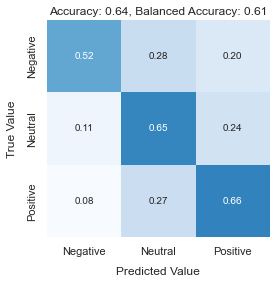

<IPython.core.display.Javascript object>

In [87]:
pipe.fit(X_train, y_train)
plotting.confusion_matrix(
    pipe, X_test, y_test, labels=pipe["cls"].classes_, size=(4, 4)
)

## Stack Classifiers

In [74]:
cls_results.param_cls.drop_duplicates()

0     LogisticRegression(class_weight='balanced', ma...
8                    LinearSVC(class_weight='balanced')
10                                       ComplementNB()
16                         SVC(class_weight='balanced')
38        ExtraTreesClassifier(class_weight='balanced')
49      RandomForestClassifier(class_weight='balanced')
72                       NuSVC(class_weight='balanced')
Name: param_cls, dtype: object

<IPython.core.display.Javascript object>

In [109]:
stack = [
    ("lr", LogisticRegression(class_weight="balanced", max_iter=1000, n_jobs=6)),
    ("sv", LinearSVC(class_weight="balanced")),
    (
        "et",
        ExtraTreesClassifier(class_weight="balanced", max_depth=3, n_estimators=500),
    ),
]

sc = StackingClassifier(
    stack,
    final_estimator=LogisticRegression(class_weight="balanced", max_iter=1000),
    n_jobs=-1,
)
sc

StackingClassifier(estimators=[('lr',
                                LogisticRegression(class_weight='balanced',
                                                   max_iter=1000, n_jobs=6)),
                               ('sv', LinearSVC(class_weight='balanced')),
                               ('et',
                                ExtraTreesClassifier(class_weight='balanced',
                                                     max_depth=3,
                                                     n_estimators=500))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=1000),
                   n_jobs=-1)

<IPython.core.display.Javascript object>

In [110]:
pipe.set_params(cls=sc)

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('freq',
                                                 FreqVectorizer(ngram_range=(1,
                                                                             2),
                                                                stemmer='wordnet',
                                                                stop_words={'#sxsw',
                                                                            '#sxswi',
                                                                            'a',
                                                                            'about',
                                                                            'above',
                                                                            'after',
                                                                            'again',
                                                     

<IPython.core.display.Javascript object>

[Pipeline] ............... (step 3 of 3) Processing cls, total=   5.2s


<AxesSubplot:title={'center':'Accuracy: 0.62, Balanced Accuracy: 0.62'}, xlabel='Predicted Value', ylabel='True Value'>

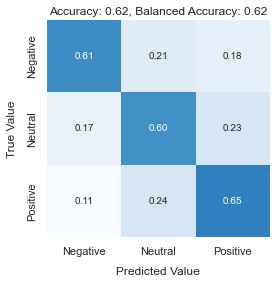

<IPython.core.display.Javascript object>

In [111]:
pipe.fit(X_train, y_train)
plotting.confusion_matrix(
    pipe, X_test, y_test, labels=pipe["cls"].classes_, size=(4, 4)
)

### Fitting the Model

Looks like the best settings are to use all scores ('pos', 'neg', 'neu', 'comp'), trinarize them (-1.0, 0.0, 1.0 sign indicators), and apply L1 normalization.

{'col__vad__category': True,
 'col__vad__compound': True,
 'col__vad__norm': 'l1',
 'col__vad__trinarize': True}

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.308,0.811,0.608,0.576,0.712,0.670,0.660
recall,0.631,0.669,0.679,0.660,0.670,,
f1-score,0.414,0.734,0.641,0.596,0.683,,
support,0.064,0.605,0.332,,,,


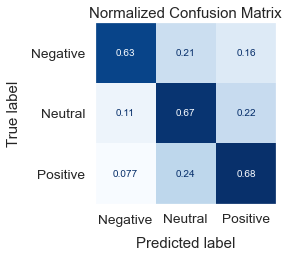

<IPython.core.display.Javascript object>

In [81]:
choice = 0

# Get params from search results and set them
pipe.set_params(**results.iloc[choice].params)

# Show what I'm setting
display(results.iloc[choice].params)

diag.test_fit(pipe, **split_data)

It's a dramatic improvement of almost 0.3 in balanced accuracy. Recall is up all around and so is precision. Average precision increased by about 0.2.

Since I have three vectorizers running, my next step is to try feature selection.

## Add Feature Selection

In the cell below, I run the `X_train` through `col_xform` (which contains the vectorizers) to remind myself how many features it's putting out.

In [82]:
pipe["col"].fit_transform(X_train)

<6659x8487 sparse matrix of type '<class 'numpy.float64'>'
	with 162070 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

Currently the model is being trained on ~8,500 features, which is a pretty high number. It's certainly workable, especially since the large vectors are sparse and contain mostly zeros. Nevertheless, perhaps reducing the number of features in a principled manner would improve model performance.

In [83]:
pipe["col"].set_params(bra="drop")
pipe.steps.insert(-1, ("sel", SelectPercentile(percentile=30)))
pipe

Pipeline(steps=[('col',
                 ColumnTransformer(transformers=[('txt',
                                                  FreqVectorizer(mark='neg_split',
                                                                 norm='l1',
                                                                 stemmer='porter',
                                                                 token_pattern=None,
                                                                 tokenizer=<bound method NLTKWordTokenizer.tokenize of <nltk.tokenize.destructive.NLTKWordTokenizer object at 0x000001FEB0E4A670>>,
                                                                 use_idf=True),
                                                  'text'),
                                                 ('bra', 'drop', 'brand_terms'),
                                                 ('vad',
                                                  VaderVectorizer(norm='l1',
                                          

<IPython.core.display.Javascript object>

After some playing around, I find that dropping the 'brand_terms' vectorizer entirely and then keeping only features in the top 30th percentile of ANOVA F-values improves the model. The brand terms probably don't contribute much novel information, since brand-related terms are already features of the TF\*IDF vectors. 

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.295,0.810,0.597,0.567,0.707,0.657,0.662
recall,0.667,0.649,0.670,0.662,0.657,,
f1-score,0.409,0.720,0.631,0.587,0.671,,
support,0.064,0.605,0.332,,,,


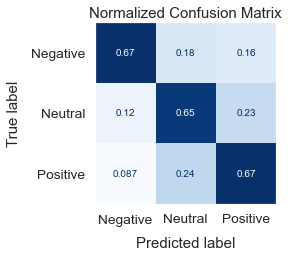

<IPython.core.display.Javascript object>

In [84]:
diag.test_fit(pipe, **split_data)

Negative recall is now a high 0.67, which is about equal to Positive recall. Balanced accuracy has gone up slightly as a result.

In [85]:
pipe[:-1].fit_transform(X_train, y_train)

<6659x2543 sparse matrix of type '<class 'numpy.float64'>'
	with 127923 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

Now the model is being trained on a mere ~2,500 features. Too bad there aren't any more parameter sweeps to run, because they would be noticeably faster.

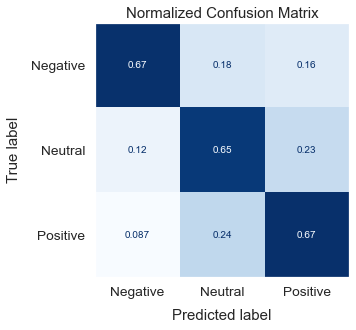

<IPython.core.display.Javascript object>

In [86]:
fig = diag.classification_plots(
    pipe.fit(X_train, y_train), X_test, y_test, pos_label="Positive"
)
fig.savefig(normpath("images/final_confusion_matrix.svg"))
fig.savefig(normpath("images/final_confusion_matrix.png"))

## Final Model

After considerable experimentation and engineering, the final model's balanced accuracy of 0.66 vastly surpasses that of the baseline (0.59). I've reproduced the baseline below, for reference.

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.384,0.770,0.609,0.588,0.692,0.690,0.589
recall,0.376,0.751,0.640,0.589,0.690,,
f1-score,0.380,0.760,0.624,0.588,0.691,,
support,0.064,0.605,0.332,,,,


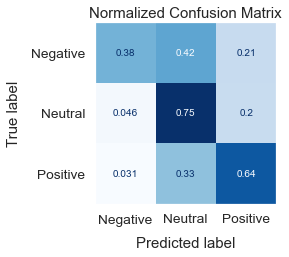

<IPython.core.display.Javascript object>

In [87]:
diag.test_fit(baseline, **split_data)

The `FreqVectorizer` assigned to the text is one of the two most important components in the pipeline (along with the classifier). I put considerable effort into trying to optimize its preprocessing parameters. The most important decisions were the choice of tokenizer, stemmer, and word-markers. I chose the high-scoring combination of `nltk.NLTKWordTokenizer`, Porter stemmer, and negation markers. Marking negation means that words which fall between a negating word and sentence punctuation get marked 'NEG'. Ordinarily, 'NEG' markers are joined with underscore to the words they mark. However, I took the unorthodox approach of placing the 'NEG' markers directly in the bags-of-words as independent tokens.

With regard to filtering, the text is simply lowercased and html entities are decoded into symbols. No stopwords were chosen. As it turns out, many stopwords and punctuation symbols are associated with the Neutral class.

In [88]:
pipe["col"]

ColumnTransformer(transformers=[('txt',
                                 FreqVectorizer(mark='neg_split', norm='l1',
                                                stemmer='porter',
                                                token_pattern=None,
                                                tokenizer=<bound method NLTKWordTokenizer.tokenize of <nltk.tokenize.destructive.NLTKWordTokenizer object at 0x000001FEB0E4A670>>,
                                                use_idf=True),
                                 'text'),
                                ('bra', 'drop', 'brand_terms'),
                                ('vad',
                                 VaderVectorizer(norm='l1', trinarize=True),
                                 'text')])

<IPython.core.display.Javascript object>

Originally I had binary occurrence vectors for regex-extracted brand terms. At the end, I discovered that these brand terms were no longer helping the model. Roughly the same information is contained in the text TF\*IDF vectors.

The `VaderVectorizer` was a late addition to the pipeline, and it brought a substantial increase in balanced accuracy. I opted to trinarize the VADER scores, i.e. reduce them to ternary sign indicators (-1.0, 0.0, 1.0).

In [89]:
pipe[1:]

Pipeline(steps=[('sel', SelectPercentile(percentile=30)),
                ('cls',
                 LogisticRegression(C=10.0, class_weight='balanced',
                                    fit_intercept=False, max_iter=1000,
                                    multi_class='multinomial',
                                    random_state=RandomState(MT19937) at 0x1FEAE5A5640,
                                    solver='newton-cg'))])

<IPython.core.display.Javascript object>

The addition of the `SelectPercentile` estimator was an important development because it reduced the ultimate vector size from ~8,500 to ~2,500. This resulted in a cleaner, more accurate, and more easily interpretable model.

And of course, the `LogisticRegression` itself is an essential component. It significantly outperformed the Naive Bayes and Linear SVM models I created. Plus, unlike `ComplementNB`, `LogisticRegression` is able to handle negative values. This allows for the addition of VADER vectors to the mix.

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.295,0.810,0.597,0.567,0.707,0.657,0.662
recall,0.667,0.649,0.670,0.662,0.657,,
f1-score,0.409,0.720,0.631,0.587,0.671,,
support,0.064,0.605,0.332,,,,


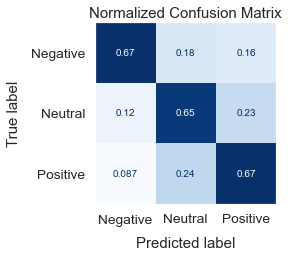

<IPython.core.display.Javascript object>

In [90]:
diag.test_fit(pipe, **split_data)

The final model has both high positive recall (0.67) and high negative recall (0.67). The high Negative recall is particularly impressive given the extremely low support (~6%) for the Negative class. The lackluster Neutral recall is not too worrisome, because the Neutral class is the least important. The Positive and Negative classes offer the most interesting material for Apple's market research.

## Refit with Final Parameters

In [91]:
pipe.fit(X, y)

Pipeline(steps=[('col',
                 ColumnTransformer(transformers=[('txt',
                                                  FreqVectorizer(mark='neg_split',
                                                                 norm='l1',
                                                                 stemmer='porter',
                                                                 token_pattern=None,
                                                                 tokenizer=<bound method NLTKWordTokenizer.tokenize of <nltk.tokenize.destructive.NLTKWordTokenizer object at 0x000001FEB0E4A670>>,
                                                                 use_idf=True),
                                                  'text'),
                                                 ('bra', 'drop', 'brand_terms'),
                                                 ('vad',
                                                  VaderVectorizer(norm='l1',
                                          

<IPython.core.display.Javascript object>

# Interpretation

The first order of business is to label the coefficients.

In [92]:
feat_names = pipe["col"].get_feature_names()
feat_names = np.array(feat_names)

# Slice names with boolean mask from 'sel'
feat_names = feat_names[pipe["sel"].get_support()]

classes = pipe["cls"].classes_
coef = pd.DataFrame(pipe["cls"].coef_, columns=feat_names, index=classes).T

# coef.rename({"bra__": "bra__none"}, inplace=True)
coef.sort_values("Negative", ascending=False)

,Negative,Neutral,Positive
txt__headach,10.893108,-5.545003,-5.348105
txt__fail,9.962107,-5.850980,-4.111127
txt__fade,9.024025,-5.084594,-3.939431
txt__long,8.728936,-3.996980,-4.731956
txt__crash,7.603669,-3.203684,-4.399985
...,...,...,...
txt__{,-6.090938,4.919628,1.171311
txt__},-6.098581,4.995304,1.103277
txt__link,-6.279301,4.662615,1.616686
txt__at,-6.377992,4.972304,1.405688


<IPython.core.display.Javascript object>

## Top 25 Overall
Then I examine the 25 coefficients with the largest magnitude.

In [93]:
top25 = coef.abs().max(axis=1).sort_values().tail(25).index
top25

Index(['txt__batteri', 'txt__link', 'txt__too', 'txt__at', 'txt__free',
       'txt__it', 'txt__love', 'txt__whi', 'txt__great', 'txt__becaus',
       'txt__iphon', 'txt__ridic.', 'txt__&', 'txt__delet', 'txt__again',
       'txt__button', 'txt__ipad', 'txt__crash', 'txt__long', 'txt__app',
       'txt__fade', 'txt__!', 'txt__cool', 'txt__fail', 'txt__headach'],
      dtype='object')

<IPython.core.display.Javascript object>

Most of the top 25 coefficients are from the TF\*IDF word vectors, unsurprisingly. As predicted, '!' shows up as a top positive coefficient. Another notable top positive term is 'ipad'. Punctuation and very common stopword-like words are related to 'Neutral'.

'images\\top25_coef.svg'

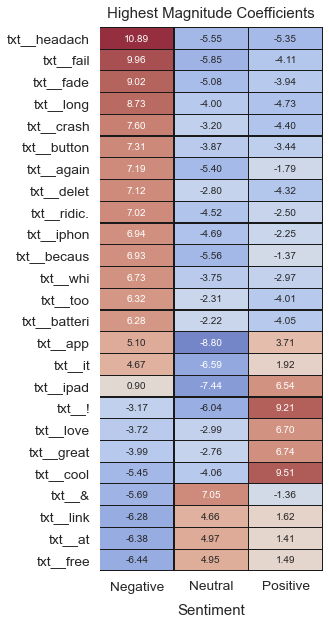

<IPython.core.display.Javascript object>

In [94]:
fig, ax = plt.subplots(figsize=(4, 10))
hm_style = dict(plotting.HEATMAP_STYLE)
del hm_style["square"]

sns.heatmap(
    coef.loc[top25].sort_values("Negative", ascending=False),
    ax=ax,
    square=False,
    **hm_style,
)

ax.set(xlabel="Sentiment")
ax.set_title("Highest Magnitude Coefficients", pad=10)
plotting.save(fig, "images/top25_coef.svg")

Interesting that the largest overall coefficient is for 'Negative'. Also the maxima are greater in magnitude than the minima.

<AxesSubplot:>

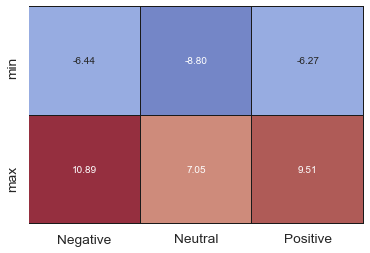

<IPython.core.display.Javascript object>

In [95]:
sns.heatmap(
    coef.agg(["min", "max"]),
    square=False,
    **hm_style,
)

I create a function for grabbing and formatting subsets of the coefficients.

In [96]:
def get_coefs(
    prefix,
    index_name,
    coef=coef,
    titlecase=True,
    icase=False,
):
    data = coef.filter(regex=fr"^{prefix}__", axis=0)

    # Remove prefix
    data.index = data.index.str.replace("\w+__", "", regex=True)

    # Make snake_case titlecase
    data.index.name = index_name
    if titlecase:
        data = utils.title_mode(data)
        if icase:
            data.index = data.index.str.replace("Ip", "iP")
    return data.sort_values("Positive")

<IPython.core.display.Javascript object>

## TF\*IDF Words

The TF\*IDF features were the most influential overall. While the unigram term coefficients from the model are not *completely* useless for brand-related research, they are too coarse-grained and simplistic. See my EDA notebook ([exploratory.ipynb](exploratory.ipynb)) for a deeper brand-related examination of TF\*IDF keywords.

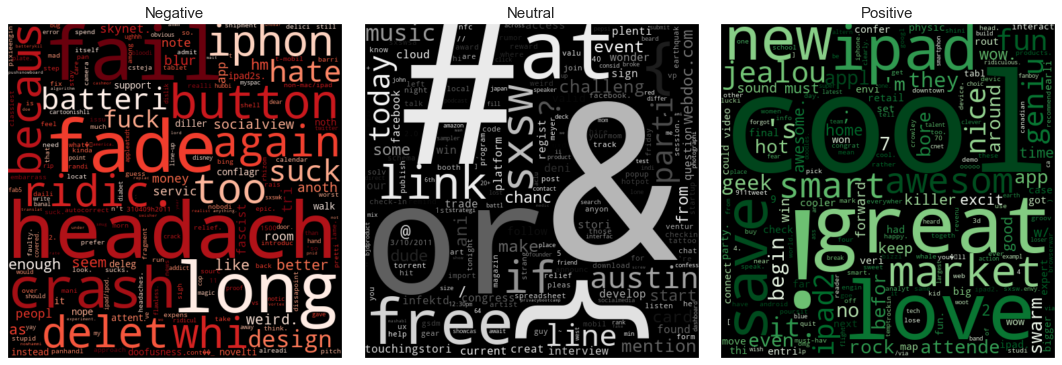

<IPython.core.display.Javascript object>

In [97]:
text_coef = get_coefs("txt", "Text", titlecase=False)

fig = plotting.wordcloud(
    text_coef,
    cmap=dict(Negative="Reds", Neutral="Greys", Positive="Greens"),
    size=(5, 5),
    random_state=rando,
)
fig.savefig(normpath("images/txt_coef_wordclouds.svg"), bbox_inches="tight")
fig.savefig(normpath("images/txt_coef_wordclouds.png"), bbox_inches="tight")

The terms in both the 'Positive' and 'Negative' wordclouds make good sense, and many of them such as 'iphon' and 'batteri' show up in the EDA wordclouds. The Neutral category is associated with punctuation and very common (stopword-like) words. That explains why no stopwords were selected.

I create a color palette for the three classes and a function for making positive vs. negative coefficient plots.

In [98]:
emo_pal = dict(Negative="r", Neutral="gray", Positive="g")
emo_pal

{'Negative': 'r', 'Neutral': 'gray', 'Positive': 'g'}

<IPython.core.display.Javascript object>

In [99]:
def pos_neg_catplot(
    coefs,
    name=None,
    drop_neutral=True,
    palette=emo_pal,
    col_wrap=4,
    sup_y=1.05,
    annot_dist=0.15,
    annot_pad=0.025,
    height=3,
):
    if drop_neutral:
        coefs = coefs.drop("Neutral", axis=1)

    # Plot bars on FacetGrid
    g = sns.catplot(
        data=coefs.reset_index(),
        col=coefs.index.name or "index",
        col_wrap=col_wrap,
        kind="bar",
        palette=palette,
        height=height,
    )

    # Annotate
    plotting.annot_bars(g.axes, orient="v", dist=annot_dist, pad=annot_pad)

    # Add horizontal y=0 line
    for ax in g.axes:
        ax.axhline(0, color="k", lw=1, alpha=0.7)

    # Set Axes titles and ylabels
    g.set_titles("{col_name}")
    g.set_ylabels("Importance")

    # Create overall title
    if name is None:
        title = "Feature Importances"
    else:
        title = f"Importance of {name}"
    g.fig.suptitle(title, y=sup_y, fontsize=16)
    return g

<IPython.core.display.Javascript object>

In [100]:
apple_coef = text_coef.loc[text_coef.index.isin({"appl", "ipad", "iphon"})]
apple_coef

,Negative,Neutral,Positive
Text,,,
iphon,6.938021,-4.687938,-2.250084
appl,0.861356,-4.859489,3.998133
ipad,0.899048,-7.441400,6.542352


<IPython.core.display.Javascript object>

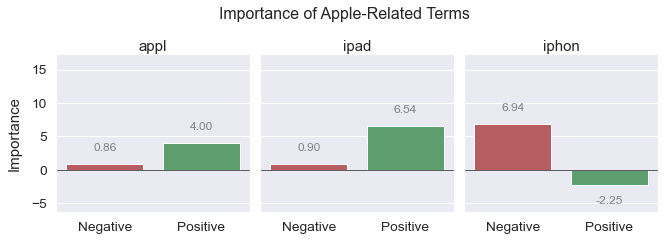

<IPython.core.display.Javascript object>

In [101]:
g = pos_neg_catplot(
    apple_coef.sort_index(),
    name="Apple-Related Terms",
    col_wrap=3,
    annot_dist=3,
    annot_pad=0.15,
    sup_y=1.1,
)

g.savefig(normpath("images/apple_tfidf_terms.svg"))
g.savefig(normpath("images/apple_tfidf_terms.png"))

Interestingly, 'iphon' has a very strong association with Negative, whereas 'ipad' has a very strong association with Positive. There were a lot of complaints about the iPhone's battery life and AT&T's unreliable service.

## VADER Valence
Here are the VADER coefficients. They are relatively large, as expected. Adding VADER vectors to the mix proved to be a good idea.

In [102]:
vad_coef = coef.filter(like="vad__", axis=0)
vad_coef.index = vad_coef.index.str.replace("vad__", "")
vad_coef = utils.title_mode(vad_coef)
vad_coef

,Negative,Neutral,Positive
Neg,1.602566,-0.840775,-0.761790
Neu,-0.255241,0.484427,-0.229186
Pos,-0.087879,-0.047055,0.134934
Compound,-0.719995,-0.216964,0.936959


<IPython.core.display.Javascript object>

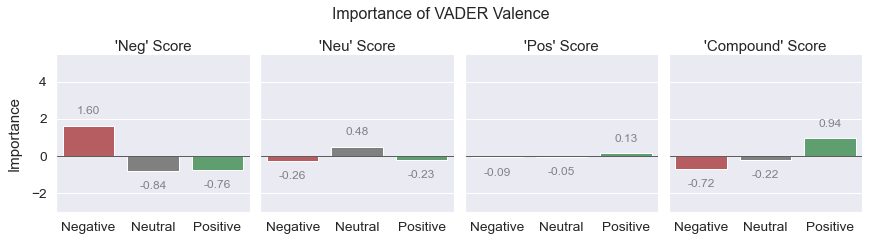

<IPython.core.display.Javascript object>

In [103]:
g = pos_neg_catplot(
    vad_coef,
    name="VADER Valence",
    col_wrap=4,
    annot_dist=1,
    annot_pad=0.1,
    sup_y=1.1,
    drop_neutral=False,
)

g.set_titles("'{col_name}' Score")
g.savefig(normpath("images/vader_coefs.svg"))
g.savefig(normpath("images/vader_coefs.png"))

The two most important VADER features were 'Neg' and 'Compound'. Unsurprisingly, 'Neg' had a strong association with Negative and a strong inverse association with Positive. 'Compound' is a summary of the other three scores which is enhanced with additional rules. It's not surprising that it had such a robust association with Positive and an inverse association with Negative. 'Neu' and 'Pos' had lackluster importance.

# Recommendations

See [exploratory.ipynb](exploratory.ipynb) for the investigation which led to my recommendations.

#### 1. Try to shake your authoritarian image by ostensibly allowing end-users more freedom.

People like that Apple products just work out of the box, but they find your paternalistic approach to managing your products off-putting. **Send the message** that when you buy an Apple product, you are free to do what you want with it. Keep control over the most important things, but relinquish control over the less important things. Make people feel like they have the freedom to customize your products as they see fit. Make some concessions to placate the majority, while allowing the elite techno-snobs to continue complaining on the fringe.

#### 2. Do something to improve the iPhone's battery life and turn it into a marketing campaign.

There were a lot complaints about the iPhone's battery life. One user suggested that their Blackberry was doing much better. There were also complaints about #batterykiller apps which use geolocation in the background. If you made a big publicized effort to increase the iPhone's battery life, that would get people excited.

#### 3. Open another temporary popup store for your next big product launch.

The iPad 2 popup store was a roaring success, and people couldn't stop talking about it. Terms like 'shiny new', 'jealous', and 'cool technology' were closely associated with the iPad 2 and popup store.

# Future Work
### Stacking Classifiers
After experimenting a little with Scikit-Learn's `StackingClassifier`, it's become clear that I could use it to develop a more accurate final model. The `StackingClassifier` trains several classifiers on the data and then trains a final classifier on the concatenated output of those classifiers. It also allows you to pass the training data to your final estimator, so the final estimator is trained both on prior data and the predictions of the classifier ensemble.

### Sophisticated Vectorization
I experimented some with Doc2Vec, a sophisticated unsupervised document vectorization algorithm, but didn't find it to offer any advantage over `FreqVectorizer` when trained on this small dataset. It proved to be slower, much more complicated, and much less interpretable. However, if trained on a large corpus of tweets, and then used to predict vectors for the present dataset, it could prove to be better than TF\*IDF vectorization. Even if the Doc2Vec vectors didn't turn out to be better than the TF\*IDF vectors, they could potentially augment them. A Doc2Vec model trained on a large corpus would probably contribute **novel information**.

# Conclusion

I created an accurate model, at around 0.66 balanced accuracy. The dataset is small, noisy, and not particularly well labeled. Nevertheless, I'm confident that I can increase the accuracy by stacking classifiers. I'd also like to try alternative methods of vectorization, but I'm not as confident that it will improve the model.

Through interpreting my model and conducting a brief exploratory analysis in [exploratory.ipynb](exploratory.ipynb), I arrived at three recommendations. First, you should publicly relinquish a small amount of control over your products to send the message that you care about individual freedom (and aren't a "fascist company"). Second, you should improve the iPhone's battery life and turn that into a rallying point for a marketing campaign. People are really concerned about the iPhone's battery life. Third, you should repeat the temporary popup store for your next big product launch. There was an overwhelming amount of chatter about the iPad 2 popup store.